# Interview Assignment

Used resources:
* https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/
* https://developers.google.com/machine-learning/guides/text-classification/
* http://users.jyu.fi/~timoh/TIES327/anomaly.pdf

### Character n-grams
A good way to tackle text machine learning problem is using n-grams. Word based n-grams don't really make sense here because extracting meaningful words from string of HTTP request wouldn't be so easy and because individual non-alphanumeric characters are also important. The case of characters was left untouched because it may play important role in some requests (eg. SQL injection).

### Tf-idf
To extract numeric features from those n-grams we use TfidfVectorizer from skicit-learn. Tf-idf works nice here because it gives the n-grams that are important for the classification higher rating. For example the 3-gram "GET" will occur in many of these requests but has no real value for the classification. On the other hand the 3-grams from SQL key-words like "SELECT", "FROM" or "DROP TABLE" will be found in most of the anomalous SQL injection requests but presumably not in many ordinary requests.

In [26]:
import os, random

import numpy as np
import matplotlib.pyplot as plt

from data_utils import *

First we load individual requests from dataset. `load_supervised_dataset` from `data_utils.py` loads and merges train and test sets, creating one set of labeled shuffled requests. 

##### Labels
* 0 - normal request
* 1 - anomalous request

In [27]:
requests, labels = load_supervised_dataset('dataset')

Because we merged train and test data (in order to get labeled dataset), we now have to split the data in two labeled train and test sets. We use 80% for training data and 20% for test data.

In [28]:
boundary = int(len(requests)*0.8)
X_train = np.array(requests[:boundary])
y_train = np.array(labels[:boundary])

X_test = np.array(requests[boundary:])
y_test = np.array(labels[boundary:])

Now we get some info about the training set.

In [29]:
print("Total # of requests: {}".format(len(X_train)))
print("# of normal requests: {}".format(np.count_nonzero(y_train == 0)))
print("# of anomalous requests: {}".format(np.count_nonzero(y_train == 1)))
print("normal/anomalous ratio: {}".format(np.count_nonzero(y_train == 0)/np.count_nonzero(y_train == 1)))

Total # of requests: 77649
# of normal requests: 57605
# of anomalous requests: 20044
normal/anomalous ratio: 2.8739273598084214


We can see from the output that the dataset is imbalanced with aprox. 3:1 ratio.

I don't have the computing power to do the tuning of hyperparameters and cross-validation with the whole training set, so I get random sample of 5000 requests from it.

In [30]:
mask = np.random.choice(len(X_train), 10000)
X_train_sample = X_train[mask]
y_train_sample = y_train[mask]

`tokenize_and_vectorize` uses methods mentioned at the beggining to extract features from HTTP requests strings.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

def tokenize_and_vectorize(train_requests, train_labels, test_requests):
    vectorizer = TfidfVectorizer(ngram_range=N_GRAMS_SIZE, min_df=MIN_DF, lowercase=False,
                                 strip_accents='unicode', decode_error='replace', analyzer='char')

    x_train = vectorizer.fit_transform(train_requests)
    x_test = vectorizer.transform(test_requests)
    
    selector = SelectKBest(f_classif, k=min(MAX_FEATURES, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train)
    x_test = selector.transform(x_test)

    return x_train, x_test

We are going to use 5-fold cross-validation to find out which hyperparameters work the best. First we try changing hyperparameters one by one to find out which are going to make it in final tuning.

In [32]:
from sklearn.svm import LinearSVC

# Creating 5 folds
num_folds = 5
 
n_requests_folds = np.split(X_train_sample, num_folds)
n_labels_folds = np.split(y_train_sample, num_folds)

<ErrorbarContainer object of 3 artists>

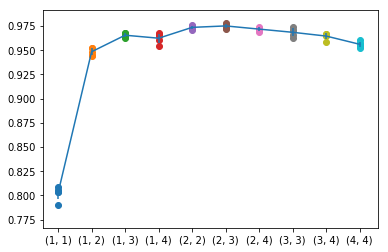

In [33]:
# Default hyperparameters
N_GRAMS_SIZE = (3, 3) # sizes of n-grams to be used
MIN_DF = 2 # minimal occurences of token for it to appear in features
MAX_FEATURES = 20000 # Maximum number of top features to select

n_gram_size_choices = [(1, 1), (1, 2), (1, 3), (1, 4), (2, 2), (2, 3), (2, 4), (3, 3), (3, 4), (4, 4)]

accuracies = {}

for (a, b) in n_gram_size_choices:   
    N_GRAMS_SIZE = (a, b)
    accuracies[(a, b)] = []
    
    for n in range(num_folds):
        X_train_val = np.concatenate([n_requests_folds[i] for i in range(num_folds) if i != n])
        y_train_val = np.concatenate([n_labels_folds[i] for i in range(num_folds) if i != n])
        X_test_val = n_requests_folds[n]
        y_test_val = n_labels_folds[n]

        X_train_val, X_test_val = tokenize_and_vectorize(X_train_val, y_train_val, X_test_val)

        classifier = LinearSVC()
        classifier.fit(X_train_val, y_train_val)

        y_test_val_pred = classifier.predict(X_test_val)
        accuracies[(a, b)].append(np.sum(y_test_val_pred == y_test_val) / y_test_val.shape[0])
        
# Plot the accuracies
accuracies_means = np.array([np.mean(v) for k,v in accuracies.items()])
accuracies_stds = np.array([np.std(v) for k,v in accuracies.items()])

for (a, b) in n_gram_size_choices:
    acc = accuracies[(a, b)]
    plt.scatter(["({}, {})".format(a, b) for i in range(len(acc))], acc)

plt.errorbar(["({}, {})".format(a, b) for a, b in n_gram_size_choices], accuracies_means, yerr=accuracies_stds)

<ErrorbarContainer object of 3 artists>

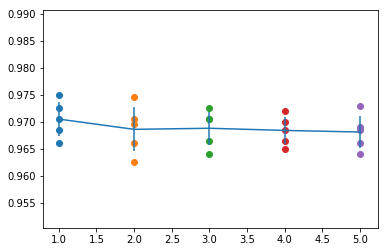

In [34]:
# Default hyperparameters
N_GRAMS_SIZE = (3, 3) # sizes of n-grams to be used
MIN_DF = 2 # minimal occurences of token for it to appear in features
MAX_FEATURES = 20000 # Maximum number of top features to select

min_df_choices = [1, 2, 3, 4, 5]

accuracies = {}

for df in min_df_choices:
    MIN_DF = df
    accuracies[df] = []
    
    for n in range(num_folds):
        X_train_val = np.concatenate([n_requests_folds[i] for i in range(num_folds) if i != n])
        y_train_val = np.concatenate([n_labels_folds[i] for i in range(num_folds) if i != n])
        X_test_val = n_requests_folds[n]
        y_test_val = n_labels_folds[n]

        X_train_val, X_test_val = tokenize_and_vectorize(X_train_val, y_train_val, X_test_val)

        classifier = LinearSVC()
        classifier.fit(X_train_val, y_train_val)

        y_test_val_pred = classifier.predict(X_test_val)
        accuracies[df].append(np.sum(y_test_val_pred == y_test_val) / y_test_val.shape[0])

# Plot the accuracies
accuracies_means = np.array([np.mean(v) for k,v in accuracies.items()])
accuracies_stds = np.array([np.std(v) for k,v in accuracies.items()])

for df in min_df_choices:
    acc = accuracies[df]
    plt.scatter([df] * len(acc), acc)

plt.errorbar([df for df in min_df_choices], accuracies_means, yerr=accuracies_stds)

1000
5000
10000
20000
30000


<ErrorbarContainer object of 3 artists>

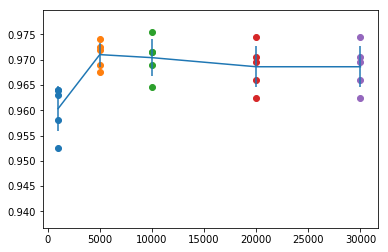

In [35]:
# Default hyperparameters
N_GRAMS_SIZE = (3, 3) # sizes of n-grams to be used
MIN_DF = 2 # minimal occurences of token for it to appear in features
MAX_FEATURES = 20000 # Maximum number of top features to select

max_features_choices = [1000, 5000, 10000, 20000, 30000]

accuracies = {}

for max_f in max_features_choices:
    print(max_f)

    MAX_FEATURES = max_f
    accuracies[max_f] = []
    
    for n in range(num_folds):
        X_train_val = np.concatenate([n_requests_folds[i] for i in range(num_folds) if i != n])
        y_train_val = np.concatenate([n_labels_folds[i] for i in range(num_folds) if i != n])
        X_test_val = n_requests_folds[n]
        y_test_val = n_labels_folds[n]

        X_train_val, X_test_val = tokenize_and_vectorize(X_train_val, y_train_val, X_test_val)

        classifier = LinearSVC()
        classifier.fit(X_train_val, y_train_val)

        y_test_val_pred = classifier.predict(X_test_val)
        accuracies[max_f].append(np.sum(y_test_val_pred == y_test_val) / y_test_val.shape[0])

# Plot the accuracies
accuracies_means = np.array([np.mean(v) for k,v in accuracies.items()])
accuracies_stds = np.array([np.std(v) for k,v in accuracies.items()])

for max_f in max_features_choices:
    acc = accuracies[max_f]
    plt.scatter([max_f] * len(acc), acc)

plt.errorbar([max_f for max_f in max_features_choices], accuracies_means, yerr=accuracies_stds)